# Gold price prediction using regression techniques

## importing essential libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor , GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
import pickle

## Data Processing 

In [2]:
gold_data = pd.read_csv('golddaily.csv')                   #reading data from dataset.csv

In [3]:
gold_data.head()

Date  Price   Open   High    Low    Chg%
0  01-Jan-24  63320  63225  63379  63181   0.19%
1  29-Dec-23  63203  63246  63385  63051  -0.29%
2  28-Dec-23  63389  63728  63821  63333  -0.45%
3  27-Dec-23  63678  63198  63710  63179   1.04%
4  26-Dec-23  63025  63149  63198  62903   0.11%

In [4]:
# gold_data['Price'] = gold_data['Price'].int.replace(',', '').astype(float)
# gold_data['Open'] = gold_data['Open'].int.replace(',', '').astype(float)
# gold_data['High'] = gold_data['High'].int.replace(',', '').astype(float)
# gold_data['Low'] = gold_data['Low'].int.replace(',', '').astype(float)
gold_data['Chg%'] = gold_data['Chg%'].str.rstrip('%').astype(float)                       #changing datatype of change from % object to float64

In [5]:
# Convert 'Date' column to datetime format with specified format
gold_data['Date'] = pd.to_datetime(gold_data['Date'], format='%d-%b-%y')
gold_data['Date'] = pd.to_datetime(gold_data['Date'], format='%b-%y')

# Extract Year, Month, and Day
gold_data['Year'] = gold_data['Date'].dt.year
gold_data['Month'] = gold_data['Date'].dt.month
gold_data['Day'] = gold_data['Date'].dt.day

# Drop the original 'Date' column
gold_data.drop('Date', axis=1, inplace=True)


In [6]:
## Adding some noise for overcoming overfitting
synthetic_data = pd.DataFrame()

for column in gold_data.columns:
    # Generate synthetic data for each column
    synthetic_column = np.random.choice(gold_data[column], size=100)
    synthetic_data[column] = synthetic_column


In [7]:
merged_data = pd.concat([gold_data, synthetic_data])

In [8]:
merged_data

Price   Open   High    Low  Chg%  Year  Month  Day
0   63320  63225  63379  63181  0.19  2024      1    1
1   63203  63246  63385  63051 -0.29  2023     12   29
2   63389  63728  63821  63333 -0.45  2023     12   28
3   63678  63198  63710  63179  1.04  2023     12   27
4   63025  63149  63198  62903  0.11  2023     12   26
..    ...    ...    ...    ...   ...   ...    ...  ...
95  25028  51460  56287  46744  2.67  2019      3   25
96  47797  60779  47619  26151  2.12  2017      4   28
97  28252  37747  26670  26598  0.74  2017      6   27
98  30903  34138  50447  54900  1.36  2019     12   27
99  29897  60170  46239  30670  0.55  2022      5   19

[2692 rows x 8 columns]

In [ ]:
gold_data.describe()                                         

## Data Extraction

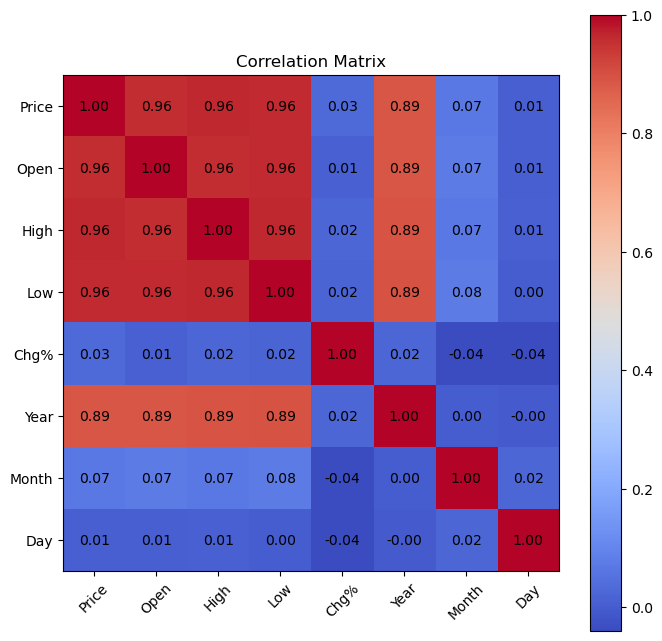

In [9]:
correlation = merged_data.corr()

plt.figure(figsize=(8, 8))
plt.title('Correlation Matrix')
plt.imshow(correlation, cmap='coolwarm', interpolation='nearest')

# Add text annotations
for i in range(len(correlation)):
    for j in range(len(correlation)):
        plt.text(j, i, f'{correlation.iloc[i, j]:.2f}', ha='center', va='center', color='black')

plt.colorbar()
plt.xticks(ticks=np.arange(len(correlation.columns)), labels=correlation.columns, rotation=45)
plt.yticks(ticks=np.arange(len(correlation.columns)), labels=correlation.columns)
plt.show()

In [10]:
print(correlation)

          Price      Open      High       Low      Chg%      Year     Month  \
Price  1.000000  0.958063  0.963888  0.960019  0.031783  0.886461  0.066200   
Open   0.958063  1.000000  0.957774  0.961218  0.009896  0.887964  0.073900   
High   0.963888  0.957774  1.000000  0.963800  0.021868  0.894060  0.068718   
Low    0.960019  0.961218  0.963800  1.000000  0.018263  0.894571  0.076167   
Chg%   0.031783  0.009896  0.021868  0.018263  1.000000  0.022592 -0.037927   
Year   0.886461  0.887964  0.894060  0.894571  0.022592  1.000000  0.002042   
Month  0.066200  0.073900  0.068718  0.076167 -0.037927  0.002042  1.000000   
Day    0.006316  0.005127  0.008848  0.004547 -0.040121 -0.000612  0.021185   

            Day  
Price  0.006316  
Open   0.005127  
High   0.008848  
Low    0.004547  
Chg%  -0.040121  
Year  -0.000612  
Month  0.021185  
Day    1.000000  


In [11]:
gold_data.isnull().sum()

Price    0
Open     0
High     0
Low      0
Chg%     0
Year     0
Month    0
Day      0
dtype: int64

In [12]:
price_column = gold_data.pop('Price')
gold_data['Price'] = price_column

In [13]:
merged_data.isnull().sum()

Price    0
Open     0
High     0
Low      0
Chg%     0
Year     0
Month    0
Day      0
dtype: int64

In [14]:
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2592 entries, 0 to 2591
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2592 non-null   int64  
 1   High    2592 non-null   int64  
 2   Low     2592 non-null   int64  
 3   Chg%    2592 non-null   float64
 4   Year    2592 non-null   int32  
 5   Month   2592 non-null   int32  
 6   Day     2592 non-null   int32  
 7   Price   2592 non-null   int64  
dtypes: float64(1), int32(3), int64(4)
memory usage: 131.8 KB


In [15]:
X = merged_data.drop('Price', axis=1)
Y = merged_data['Price']

In [16]:
X.tail()

Open   High    Low  Chg%  Year  Month  Day
95  51460  56287  46744  2.67  2019      3   25
96  60779  47619  26151  2.12  2017      4   28
97  37747  26670  26598  0.74  2017      6   27
98  34138  50447  54900  1.36  2019     12   27
99  60170  46239  30670  0.55  2022      5   19

In [17]:
from sklearn.model_selection import train_test_split


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Standardisation and Normalisation

In [19]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## LINEAR REGRESSION

In [20]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train_scaled, Y_train)

LinearRegression()

In [21]:
test_data_prediction = linear_regressor.predict(X_test_scaled)

In [22]:
test_data_prediction

array([29124.89318064, 27080.97449002, 51069.59641158, 46720.80061666,
       28308.63879006, 30806.92660893, 37708.70934251, 27397.98647696,
       29678.14461331, 29275.26108986, 29822.54202158, 29098.57657564,
       28263.30351933, 58082.87376264, 30886.96422405, 38405.34770859,
       28636.89361354, 28598.05848054, 51278.08339777, 26705.04735254,
       49719.59659356, 46418.9773753 , 26898.55654155, 33738.89096062,
       47221.0231269 , 49219.92673305, 46661.12049355, 28976.13095405,
       26442.75181061, 48625.53222743, 28788.03125484, 26830.06369519,
       50173.82764717, 54233.89172404, 46199.09511957, 49886.96109905,
       59545.08314212, 45169.49437739, 30451.37720278, 27298.08594213,
       31605.71323335, 29737.49531917, 48750.60815421, 51367.31505255,
       27475.50543976, 37793.03861332, 29757.52500624, 47389.59786432,
       50996.89516868, 47769.73056747, 29856.43911307, 58196.49348828,
       28769.26419192, 58623.22986307, 29680.27608342, 49928.44405559,
      

In [23]:
error_score = metrics.r2_score(Y_test, test_data_prediction)
mae_lr = mean_absolute_error(Y_test, test_data_prediction)
mse_lr = mean_squared_error(Y_test, test_data_prediction)
print("MAE (Linear Regression): {:.2f}".format(mae_lr))
print("MSE (Linear Regression): {:.2f}".format(mse_lr))
print("R squared error : ", error_score)


MAE (Linear Regression): 571.61
MSE (Linear Regression): 6049561.00
R squared error :  0.952546800826054


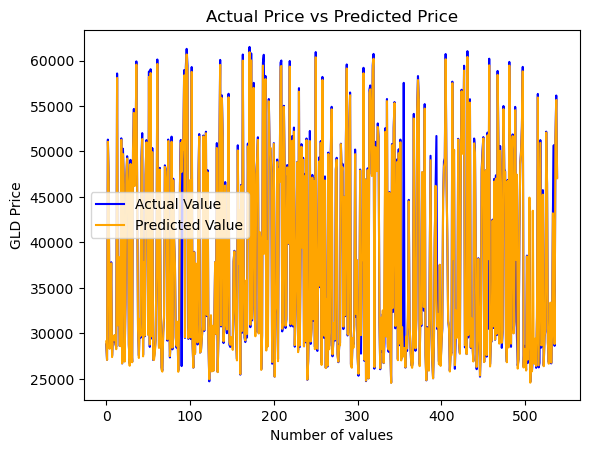

In [24]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(test_data_prediction, color='orange', label='Predicted Value')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

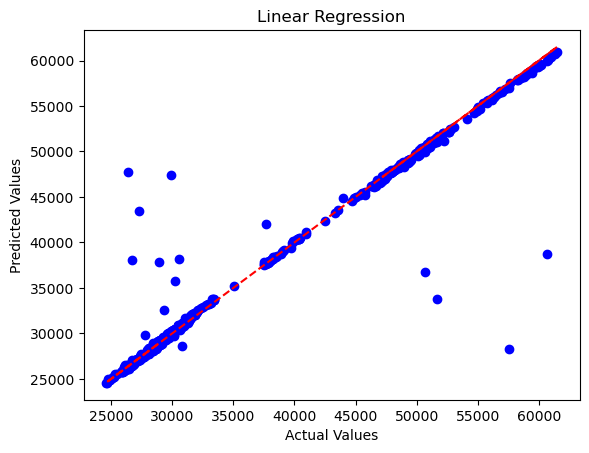

In [25]:
plt.scatter(Y_test, test_data_prediction, color='blue')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('Linear Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


C:\Users\sarka\anaconda3\envs\Projects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


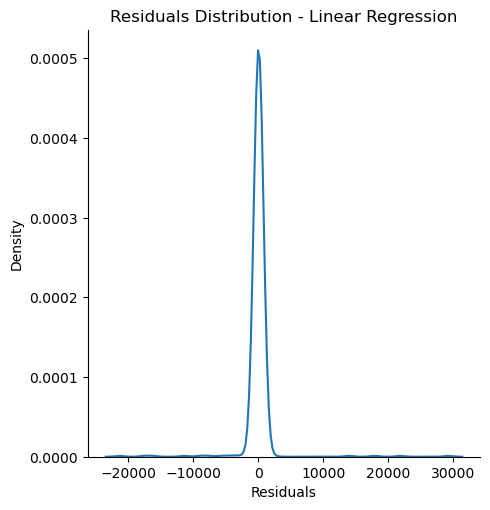

In [26]:
sns.displot(Y_test - test_data_prediction, kind='kde')
plt.title('Residuals Distribution - Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [27]:
print("Accuracy of linear Regression model: {:.2f}%".format(error_score * 100))

Accuracy of linear Regression model: 95.25%


In [28]:
pickle.dump(linear_regressor,open('linear_regressor.pkl','wb'))

## RANDOM REGRESSION

In [29]:
random_regressor = RandomForestRegressor(n_estimators=100)

In [30]:
random_regressor.fit(X_train_scaled, Y_train)

RandomForestRegressor()

In [31]:
test_data_predictionR = random_regressor.predict(X_test_scaled)

In [32]:
error_scoreR = metrics.r2_score(Y_test, test_data_predictionR) #add test_data_prediction for random forest
mae_rf = mean_absolute_error(Y_test, test_data_predictionR)
mse_rf = mean_squared_error(Y_test, test_data_predictionR)
print("MAE (Random Forest Regression): {:.2f}".format(mae_rf))
print("MSE (Random Forest Regression): {:.2f}".format(mse_rf))
print("R squared error : ", error_scoreR)

MAE (Random Forest Regression): 391.11
MSE (Random Forest Regression): 3901460.55
R squared error :  0.9693966579832293


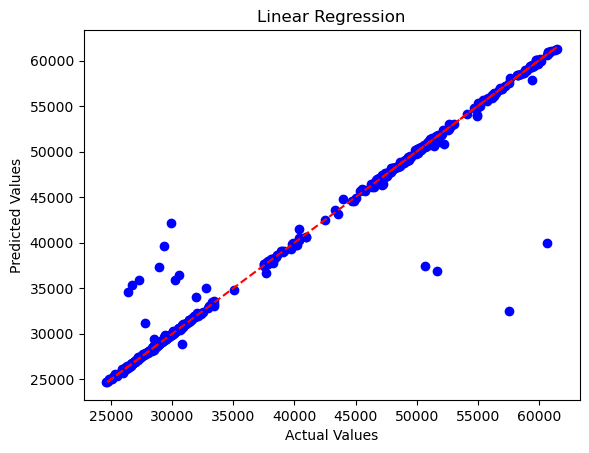

In [33]:
plt.scatter(Y_test, test_data_predictionR, color='blue')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('Linear Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

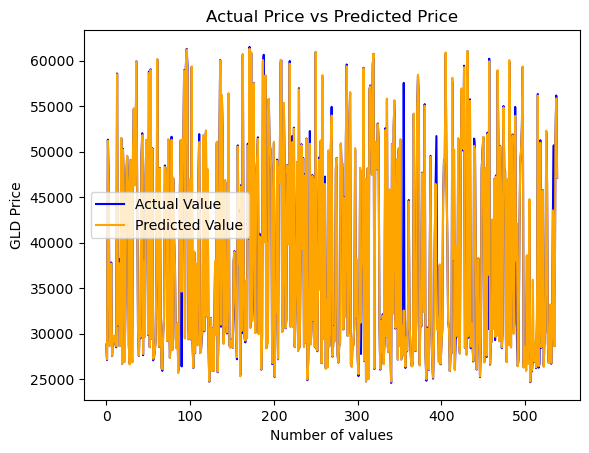

In [34]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(test_data_predictionR, color='orange', label='Predicted Value')
plt.title('Actual Price vs Predicted Price')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

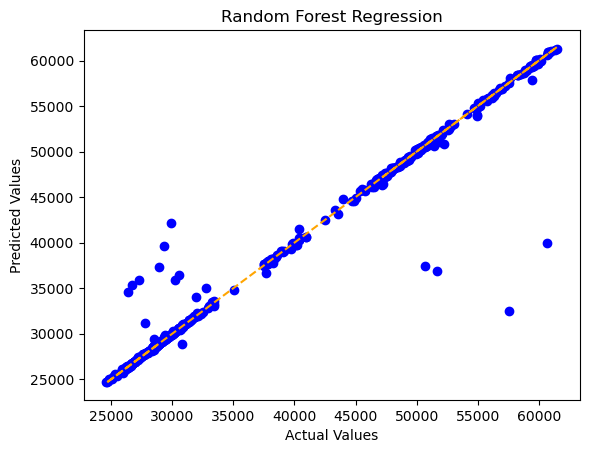

In [35]:
plt.scatter(Y_test, test_data_predictionR, color='blue')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('Random Forest Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

In [ ]:
sns.displot(Y_test - test_data_predictionR, kind='kde')
plt.title('Residuals Distribution - Random Forest Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [ ]:
print("Accuracy of random forest Regression model: {:.2f}%".format(error_scoreR * 100))

In [ ]:
pickle.dump(random_regressor,open('random_regressor.pkl','wb'))

## XGBOOST

In [36]:
import xgboost as xgb
from sklearn.metrics import r2_score

In [37]:
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train_scaled, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
Y_pred_xgb = xgb_regressor.predict(X_test_scaled)

In [39]:
Y_pred_xgb

array([28803.5  , 27192.723, 51352.54 , 46869.938, 28622.432, 30426.896,
       37929.7  , 27587.365, 29763.44 , 29139.922, 29603.336, 28879.025,
       28682.83 , 58481.973, 31083.459, 38109.195, 28666.04 , 28819.166,
       51331.68 , 26725.38 , 50217.668, 46796.547, 26934.297, 33304.152,
       47482.516, 49232.19 , 43828.52 , 28693.893, 26623.75 , 49079.37 ,
       29278.234, 26828.225, 50402.92 , 54515.312, 46323.047, 50296.926,
       59928.074, 45428.055, 30307.246, 27582.729, 31405.367, 29595.002,
       49037.26 , 51766.76 , 27739.602, 37918.09 , 29657.617, 47209.977,
       51267.023, 48081.574, 29993.58 , 59120.957, 28540.555, 59124.434,
       29540.467, 50216.24 , 27211.633, 27519.658, 28210.63 , 29470.5  ,
       37918.88 , 59821.81 , 39020.508, 28804.42 , 48112.125, 31491.354,
       26114.566, 25969.893, 30241.873, 31586.592, 48600.516, 48187.086,
       45625.55 , 29246.66 , 51421.348, 33873.637, 27279.219, 29612.18 ,
       51324.92 , 28172.508, 47218.49 , 40749.66 , 

In [40]:
r2_xgb = r2_score(Y_test, Y_pred_xgb)
mae_xgb = mean_absolute_error(Y_test, Y_pred_xgb)
mse_xgb = mean_squared_error(Y_test, Y_pred_xgb)
print("MAE (XGBoost Regression): {:.2f}".format(mae_xgb))
print("MSE (XGBoost Regression): {:.2f}".format(mse_xgb))
print("XGBoost Regression R squared error: ", r2_xgb)

MAE (XGBoost Regression): 425.59
MSE (XGBoost Regression): 4557213.80
XGBoost Regression R squared error:  0.9642528814950417


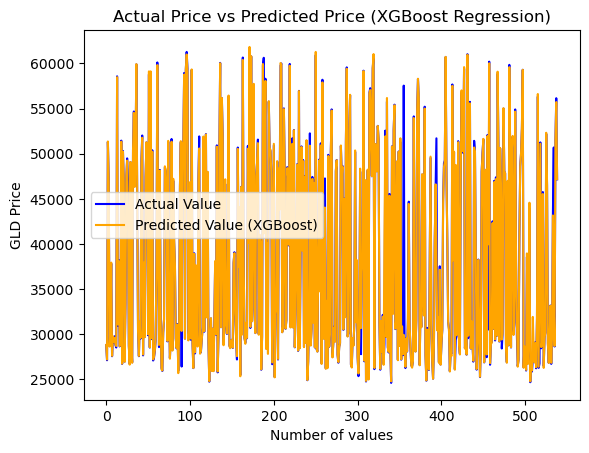

In [41]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_xgb, color='orange', label='Predicted Value (XGBoost)')
plt.title('Actual Price vs Predicted Price (XGBoost Regression)')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

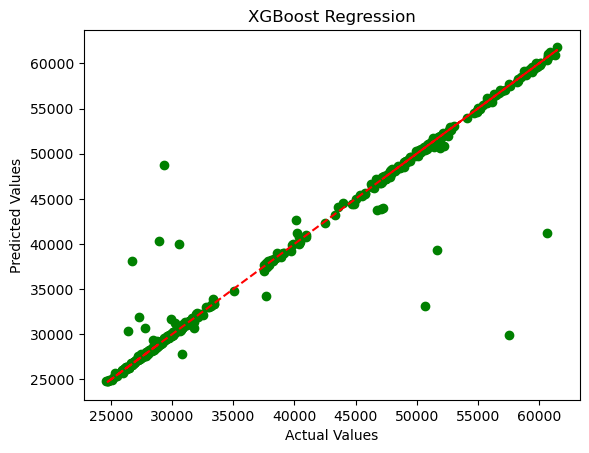

In [42]:
plt.scatter(Y_test, Y_pred_xgb, color='green')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('XGBoost Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


C:\Users\sarka\anaconda3\envs\Projects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


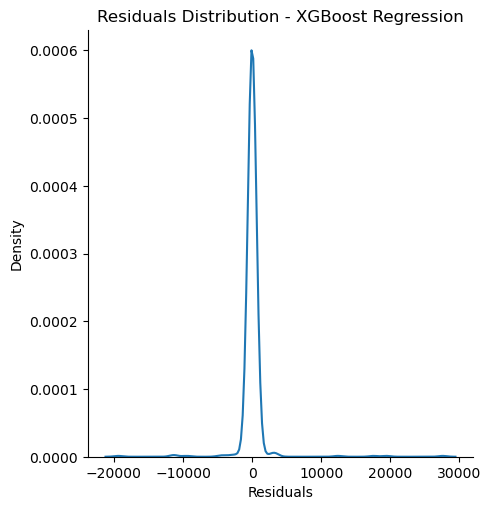

In [43]:
sns.displot(Y_test - Y_pred_xgb, kind='kde')
plt.title('Residuals Distribution - XGBoost Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [ ]:
print("Accuracy of XGBoost Regression model: {:.2f}%".format(r2_xgb * 100))

In [ ]:
pickle.dump(xgb_regressor,open('xgb_regressor.pkl','wb'))

## ADA BOOST Regression

In [44]:
adaboost_regressor = AdaBoostRegressor()

In [45]:
adaboost_regressor.fit(X_train_scaled, Y_train)

AdaBoostRegressor()

In [46]:
Y_pred_adaboost = adaboost_regressor.predict(X_test_scaled)

In [47]:
Y_pred_adaboost

array([28855.84021305, 27590.90892193, 46792.41333333, 45227.74524715,
       28855.84021305, 32593.088     , 36953.4       , 27781.50913838,
       32593.088     , 30203.70527859, 32593.088     , 28855.84021305,
       28733.33009709, 58267.13043478, 32593.088     , 36953.4       ,
       28855.84021305, 28855.84021305, 50582.49226006, 27590.90892193,
       46914.58626466, 45227.74524715, 27590.90892193, 35240.96758105,
       45227.74524715, 47852.40282132, 45227.74524715, 28855.84021305,
       27590.90892193, 47852.40282132, 28855.84021305, 27590.90892193,
       46914.58626466, 48243.33333333, 45227.74524715, 45227.74524715,
       58739.15263158, 45227.74524715, 32593.088     , 27781.50913838,
       32593.088     , 30203.70527859, 46914.58626466, 47852.40282132,
       27977.60195531, 36953.4       , 30203.70527859, 45227.74524715,
       47852.40282132, 45227.74524715, 32593.088     , 58267.13043478,
       28855.84021305, 58267.13043478, 28938.93333333, 46914.58626466,
      

In [48]:
r2_adaboost = r2_score(Y_test, Y_pred_adaboost)
mae_adaboost = mean_absolute_error(Y_test, Y_pred_adaboost)
mse_adaboost = mean_squared_error(Y_test, Y_pred_adaboost)
print("MAE (AdaBoost Regression): {:.2f}".format(mae_adaboost))
print("MSE (AdaBoost Regression): {:.2f}".format(mse_adaboost))
print("R squared error (AdaBoost Regression):", r2_adaboost)

MAE (AdaBoost Regression): 1963.60
MSE (AdaBoost Regression): 8419504.59
R squared error (AdaBoost Regression): 0.9339567898580065


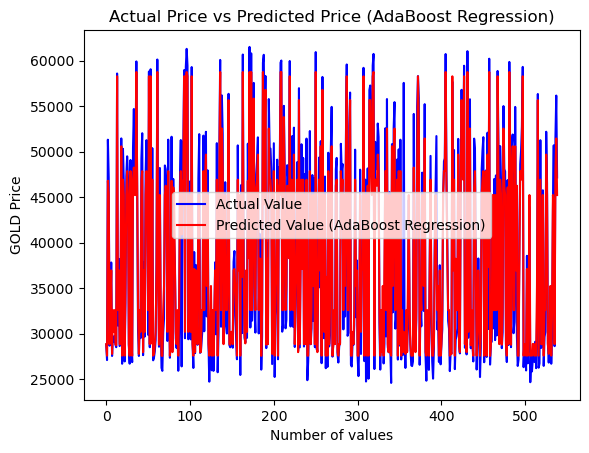

In [49]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_adaboost, color='red', label='Predicted Value (AdaBoost Regression)')
plt.title('Actual Price vs Predicted Price (AdaBoost Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()

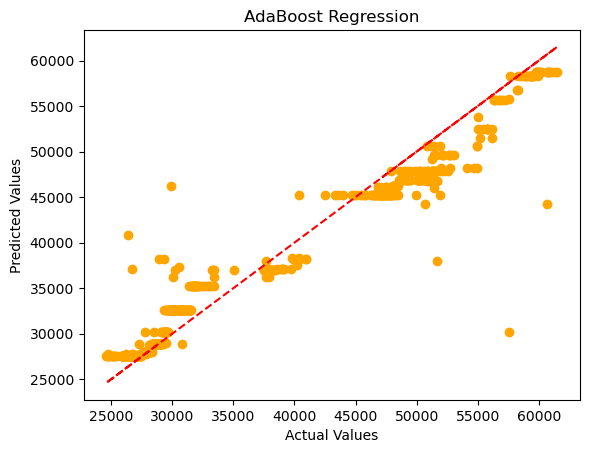

In [50]:
plt.scatter(Y_test, Y_pred_adaboost, color='orange')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('AdaBoost Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


C:\Users\sarka\anaconda3\envs\Projects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


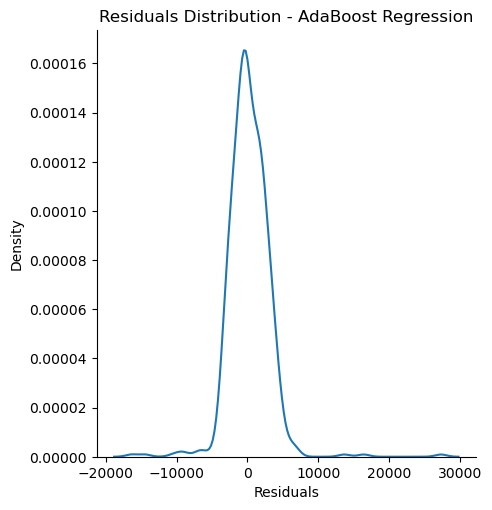

In [51]:
sns.displot(Y_test - Y_pred_adaboost, kind='kde')
plt.title('Residuals Distribution - AdaBoost Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [52]:
print("Accuracy of AdaBoost Regression model: {:.2f}%".format(r2_adaboost * 100))

Accuracy of AdaBoost Regression model: 93.40%


In [53]:
pickle.dump(adaboost_regressor,open('adaboost_regressor.pkl','wb'))

## Support Vector Machine

In [54]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from imblearn.over_sampling import RandomOverSampler

In [56]:
svm_regressor = SVR()

In [57]:
svm_regressor.fit(X_train_scaled, Y_train)

SVR()

In [58]:
# # Making predictions on the test data
Y_pred_svm = svm_regressor.predict(X_test_scaled)

In [59]:
# SVM Hyperparameter Tuning
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf', 'poly']}  #kfold cross validation, folds = 4
svm_regressor = SVR()
grid_search = GridSearchCV(svm_regressor, param_grid, scoring='r2', cv=5)
grid_search.fit(X_train_scaled, Y_train)
best_params = grid_search.best_params_
print("Best Parameters for SVM:", best_params)

# Feature Selection
selector = SelectKBest(score_func=f_regression, k=7)
X_train_selected = selector.fit_transform(X_train_scaled, Y_train)
X_test_selected = selector.transform(X_test_scaled)

# SVM with best parameters
svm_regressor = SVR(**best_params)
svm_regressor.fit(X_train_selected, Y_train)
Y_pred_svm = svm_regressor.predict(X_test_selected)
r2_svm = metrics.r2_score(Y_test, Y_pred_svm)
print("Accuracy of SVM Regression model after rectifications: {:.2f}%".format(r2_svm * 100))

# Handle Data Imbalance
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, Y_train_resampled = oversampler.fit_resample(X_train_selected, Y_train)

# SVM after handling data imbalance
svm_regressor = SVR(**best_params)
svm_regressor.fit(X_train_resampled, Y_train_resampled)
Y_pred_svm = svm_regressor.predict(X_test_selected)
r2_svm = metrics.r2_score(Y_test, Y_pred_svm)
print("Accuracy of SVM Regression model after handling data imbalance: {:.2f}%".format(r2_svm * 100))

Best Parameters for SVM: {'C': 10, 'gamma': 1, 'kernel': 'linear'}
Accuracy of SVM Regression model after rectifications: 95.44%
Accuracy of SVM Regression model after handling data imbalance: 95.43%


In [60]:
r2_svm = r2_score(Y_test, Y_pred_svm)
mae_svm = mean_absolute_error(Y_test, Y_pred_svm)
mse_svm = mean_squared_error(Y_test, Y_pred_svm)
print("MAE (SVM Regression): {:.2f}".format(mae_svm))
print("MSE (SVM Regression): {:.2f}".format(mse_svm))
print("R squared error (SVM Regression):", r2_svm)

MAE (SVM Regression): 402.50
MSE (SVM Regression): 5828238.98
R squared error (SVM Regression): 0.9542828669769038


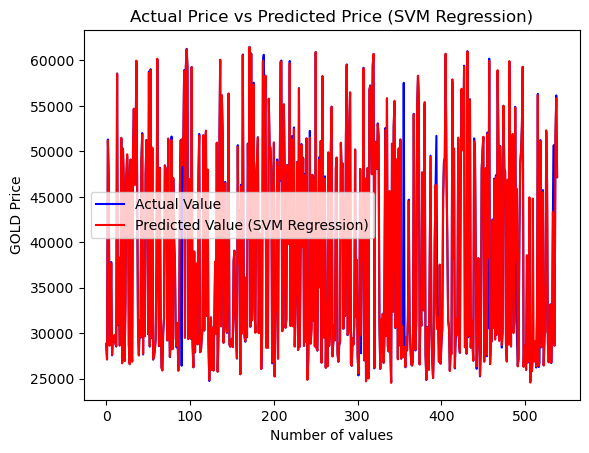

In [61]:
# Plotting Actual vs Predicted values
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_svm, color='red', label='Predicted Value (SVM Regression)')
plt.title('Actual Price vs Predicted Price (SVM Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()

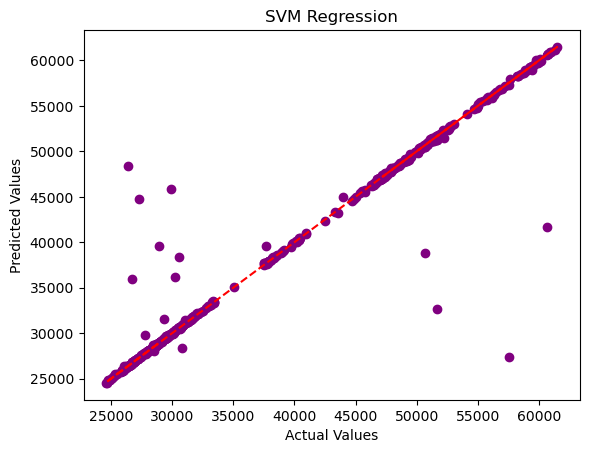

In [62]:
plt.scatter(Y_test, Y_pred_svm, color='purple')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('SVM Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


C:\Users\sarka\anaconda3\envs\Projects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


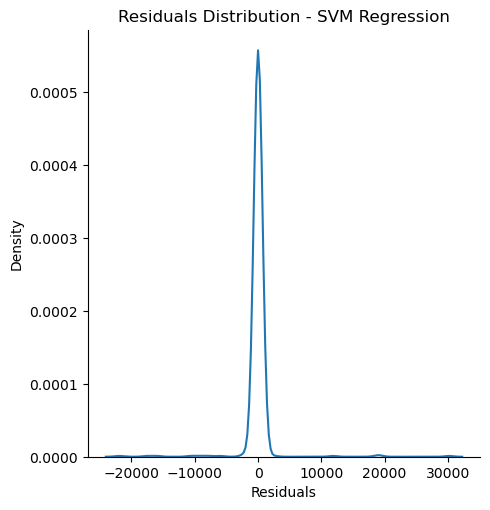

In [63]:
sns.displot(Y_test - Y_pred_svm, kind='kde')
plt.title('Residuals Distribution - SVM Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [64]:
print("Accuracy of AdaBoost Regression model: {:.2f}%".format(r2_svm * 100))

Accuracy of AdaBoost Regression model: 95.43%


In [65]:
pickle.dump(svm_regressor,open('svm_regressor.pkl','wb'))

## GRADIENT BOOST REGRESSION

In [66]:
# Instantiating the Gradient Boosting Regression model
gradient_boost_regressor = GradientBoostingRegressor()

In [67]:
gradient_boost_regressor.fit(X_train, Y_train)

GradientBoostingRegressor()

In [68]:
Y_pred_gradient_boost = gradient_boost_regressor.predict(X_test)

In [69]:
r2_gradient_boost = metrics.r2_score(Y_test, Y_pred_gradient_boost)
Y_pred_gradient_boost = gradient_boost_regressor.predict(X_test)
mae_gradient_boost = mean_absolute_error(Y_test, Y_pred_gradient_boost)
mse_gradient_boost = mean_squared_error(Y_test, Y_pred_gradient_boost)
print("MAE (Gradient Boosting Regression): {:.2f}".format(mae_gradient_boost))
print("MSE (Gradient Boosting Regression): {:.2f}".format(mse_gradient_boost))
print("R squared error (Gradient Boosting Regression):", r2_gradient_boost)

MAE (Gradient Boosting Regression): 539.39
MSE (Gradient Boosting Regression): 4780396.09
R squared error (Gradient Boosting Regression): 0.9625022232923173


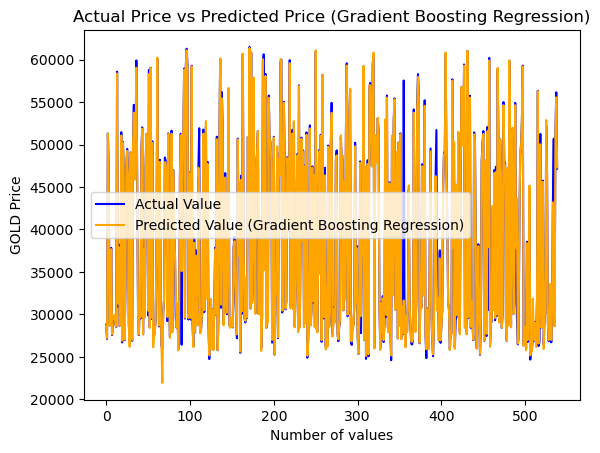

In [70]:
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_gradient_boost, color='orange', label='Predicted Value (Gradient Boosting Regression)')
plt.title('Actual Price vs Predicted Price (Gradient Boosting Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()

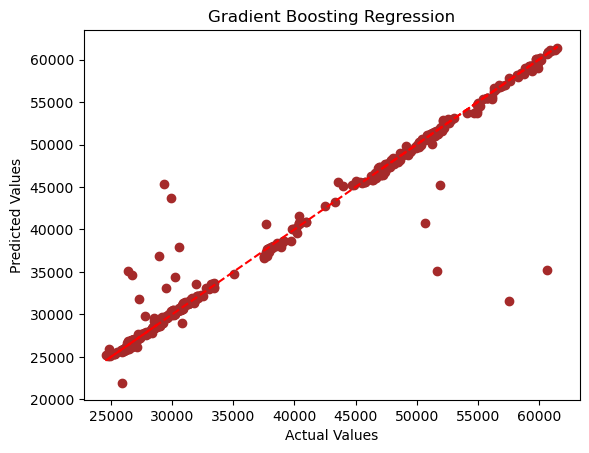

In [71]:
plt.scatter(Y_test, Y_pred_gradient_boost, color='brown')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('Gradient Boosting Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()


C:\Users\sarka\anaconda3\envs\Projects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


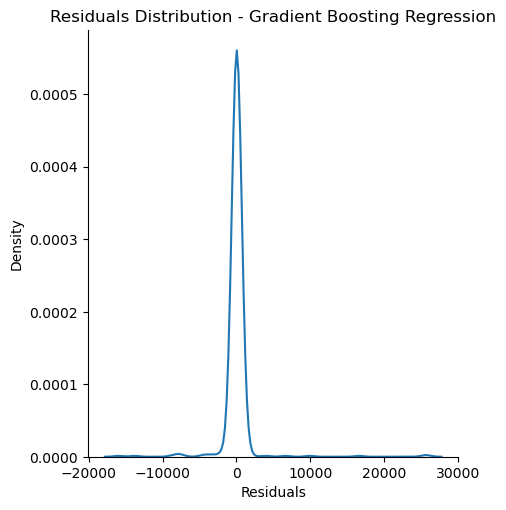

In [72]:
sns.displot(Y_test - Y_pred_gradient_boost, kind='kde')
plt.title('Residuals Distribution - Gradient Boosting Regression')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()


In [73]:
print("Accuracy of Gradient Boost Regression model: {:.2f}%".format(r2_gradient_boost * 100))

Accuracy of Gradient Boost Regression model: 96.25%


In [74]:
pickle.dump(gradient_boost_regressor,open('gradient_boost_regressor.pkl','wb'))

# ---------------------------RESULT SUMMARY---------------------------

In [75]:
import pandas as pd

# Create a dictionary to store the metrics of each regression model
metrics_data = {
    'Regression': ['Linear', 'Random Forest', 'XGBoost', 'AdaBoost', 'SVM', 'Gradient Boost'],
    'MAE': [mae_lr, mae_rf, mae_xgb, mae_adaboost, mae_svm, mae_gradient_boost],
    'MSE': [mse_lr, mse_rf, mse_xgb, mse_adaboost, mse_svm, mse_gradient_boost],
    'R2': [error_score, error_scoreR, r2_xgb, r2_adaboost, r2_svm, r2_gradient_boost],
    'Accuracy': [error_score * 100, error_scoreR * 100, r2_xgb * 100, r2_adaboost * 100, r2_svm * 100, r2_gradient_boost * 100]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_data)

# Display the DataFrame
print(metrics_df)


       Regression          MAE           MSE        R2   Accuracy
0          Linear   571.611998  6.049561e+06  0.952547  95.254680
1   Random Forest   391.114434  3.901461e+06  0.969397  96.939666
2         XGBoost   425.588340  4.557214e+06  0.964253  96.425288
3        AdaBoost  1963.598655  8.419505e+06  0.933957  93.395679
4             SVM   402.500137  5.828239e+06  0.954283  95.428287
5  Gradient Boost   539.385226  4.780396e+06  0.962502  96.250222


## PLOT

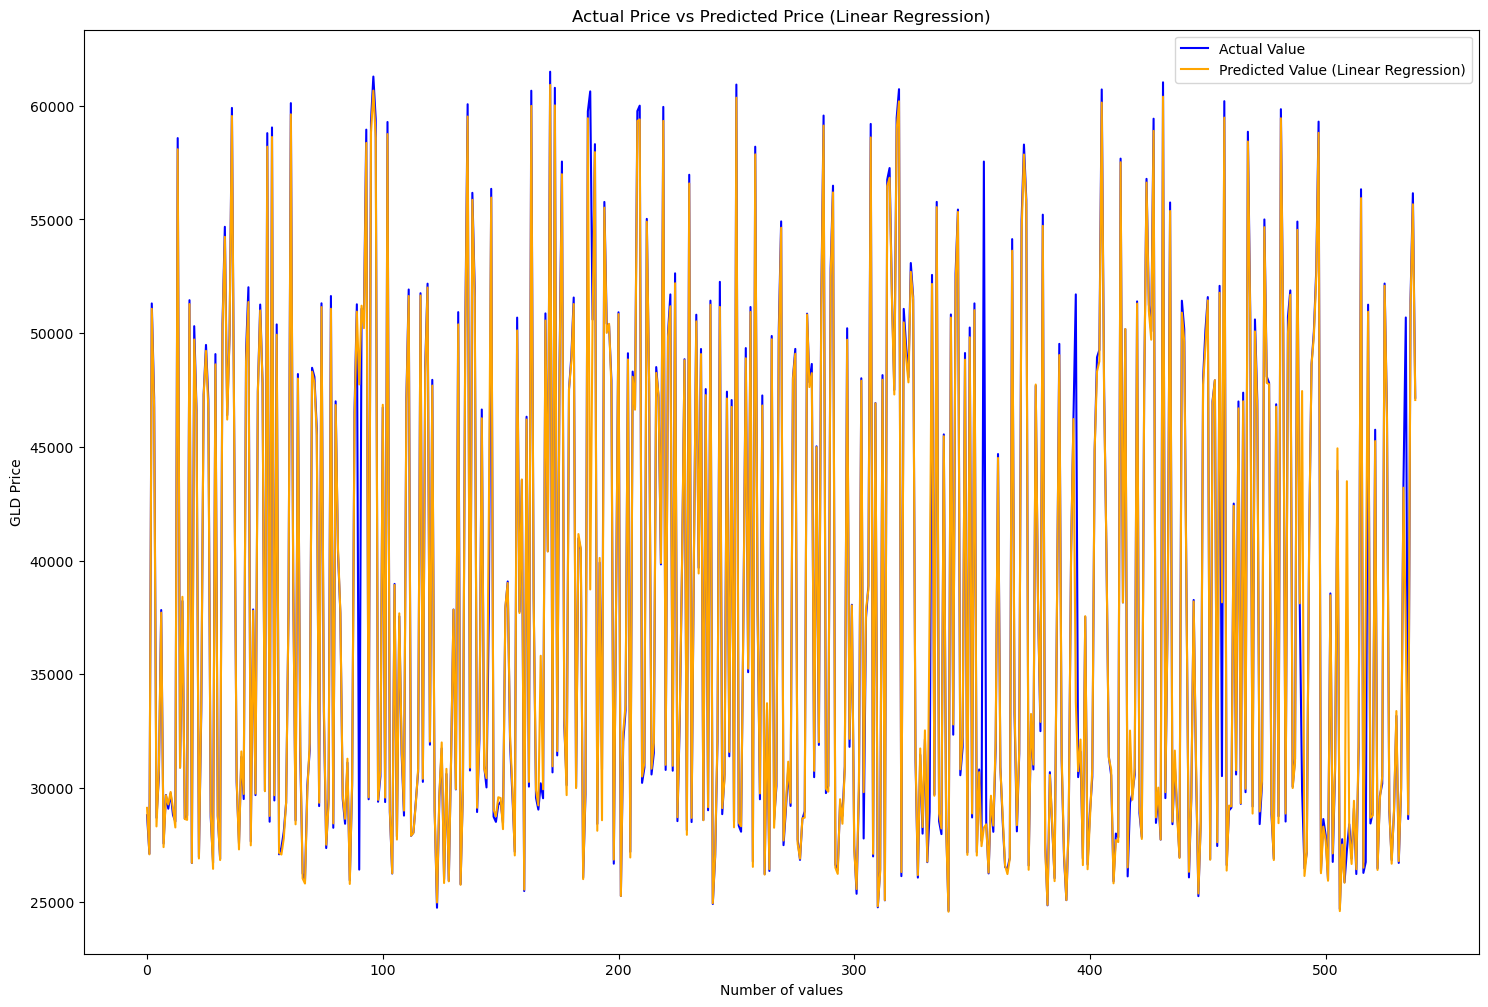

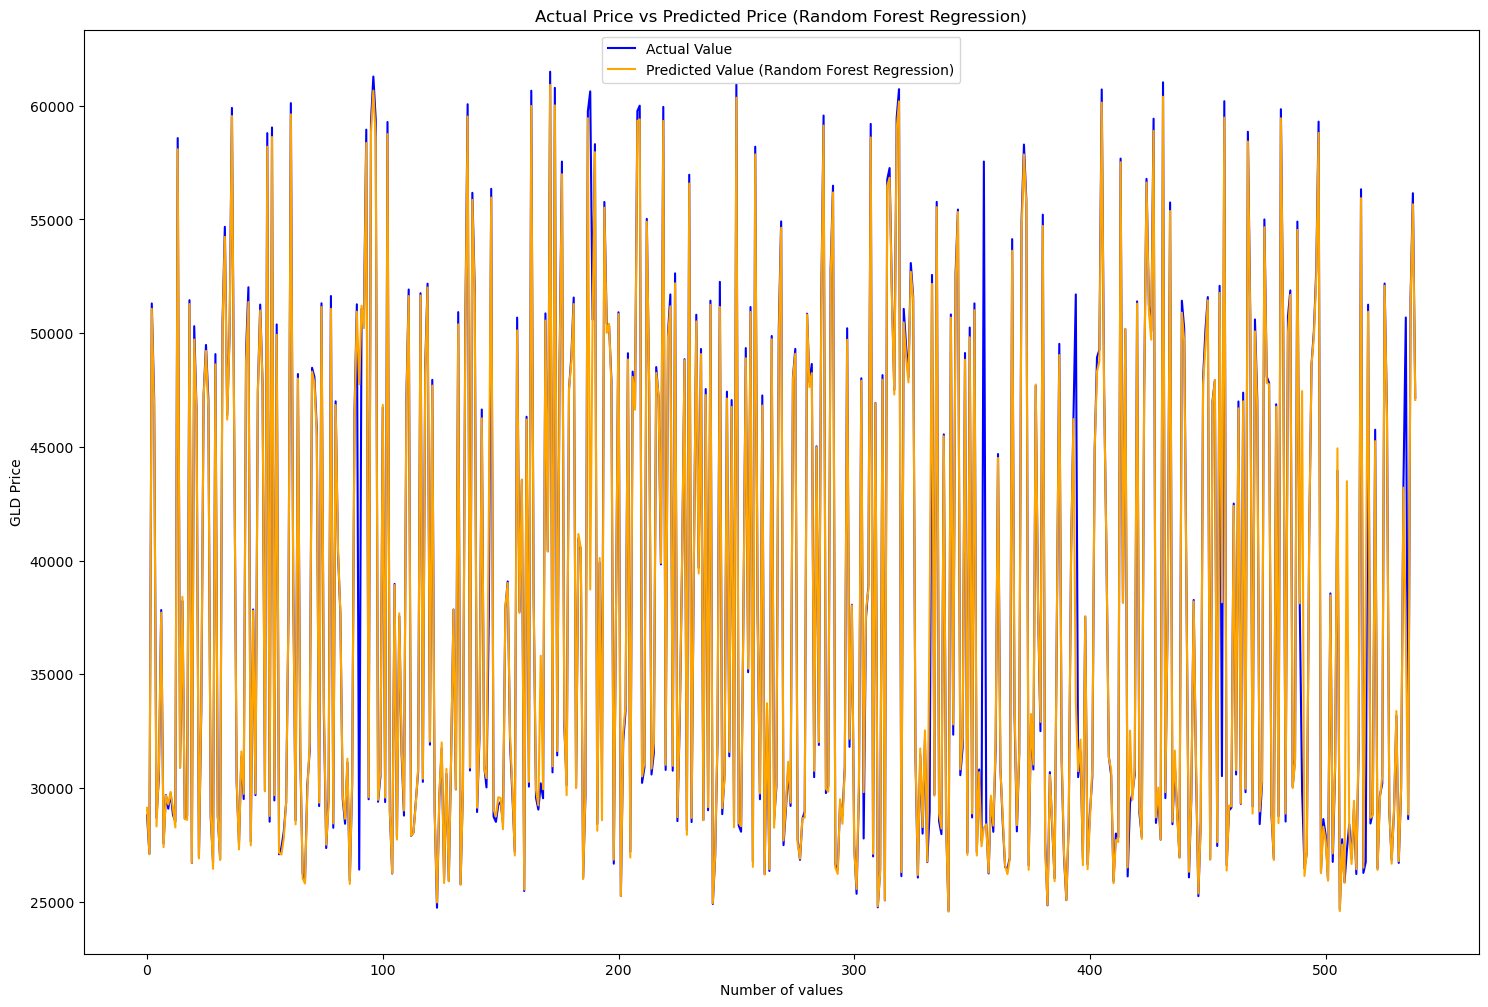

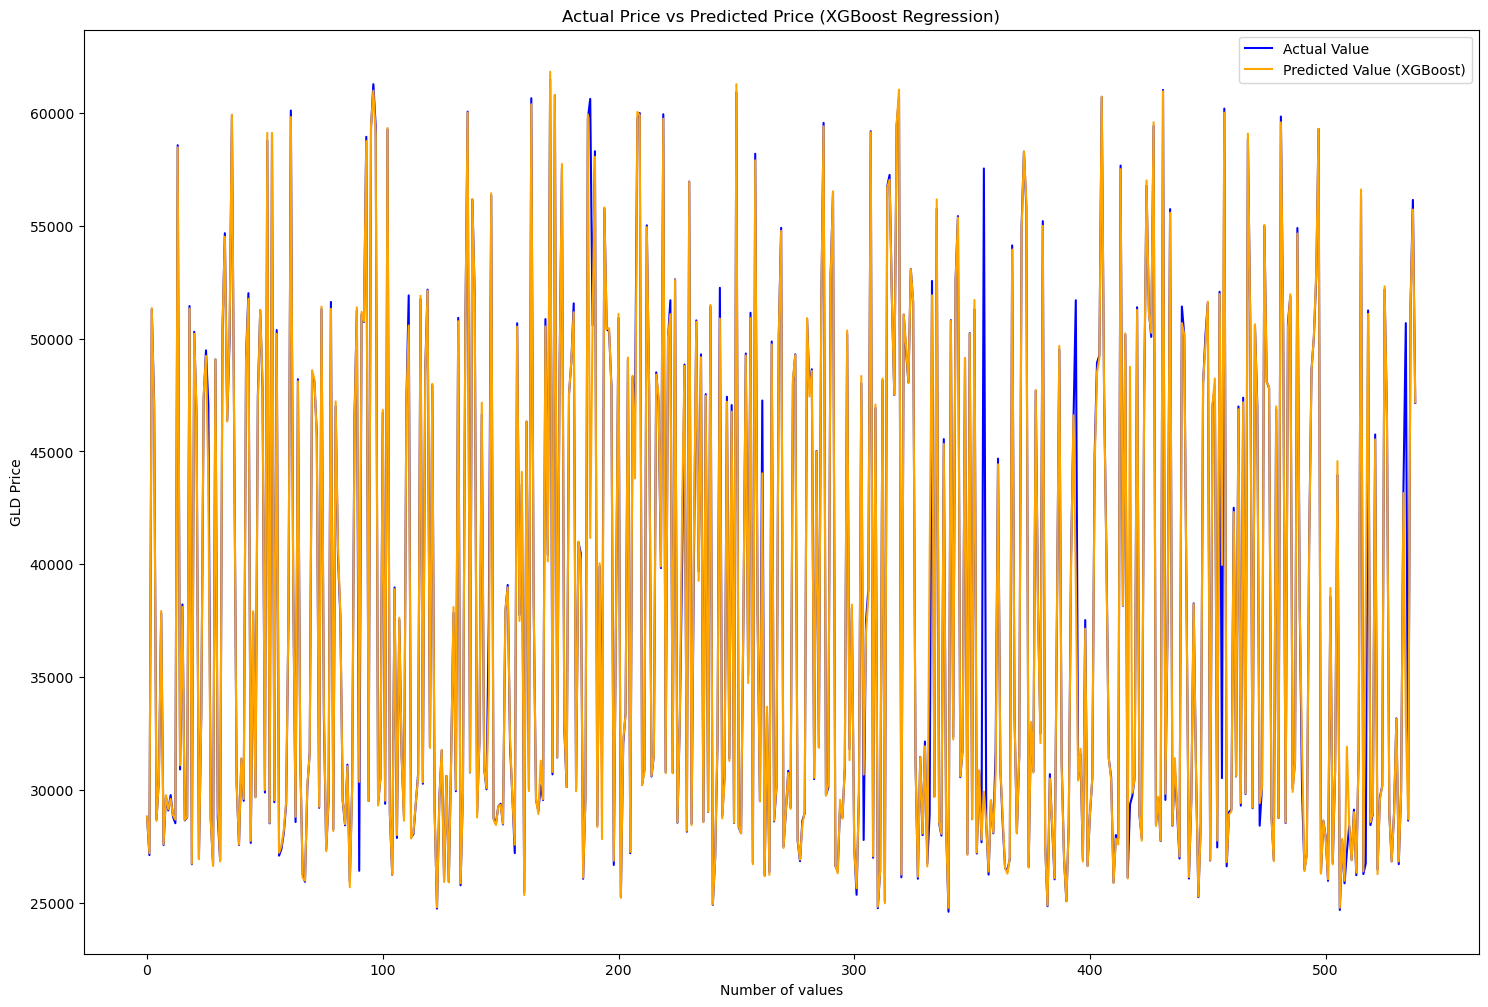

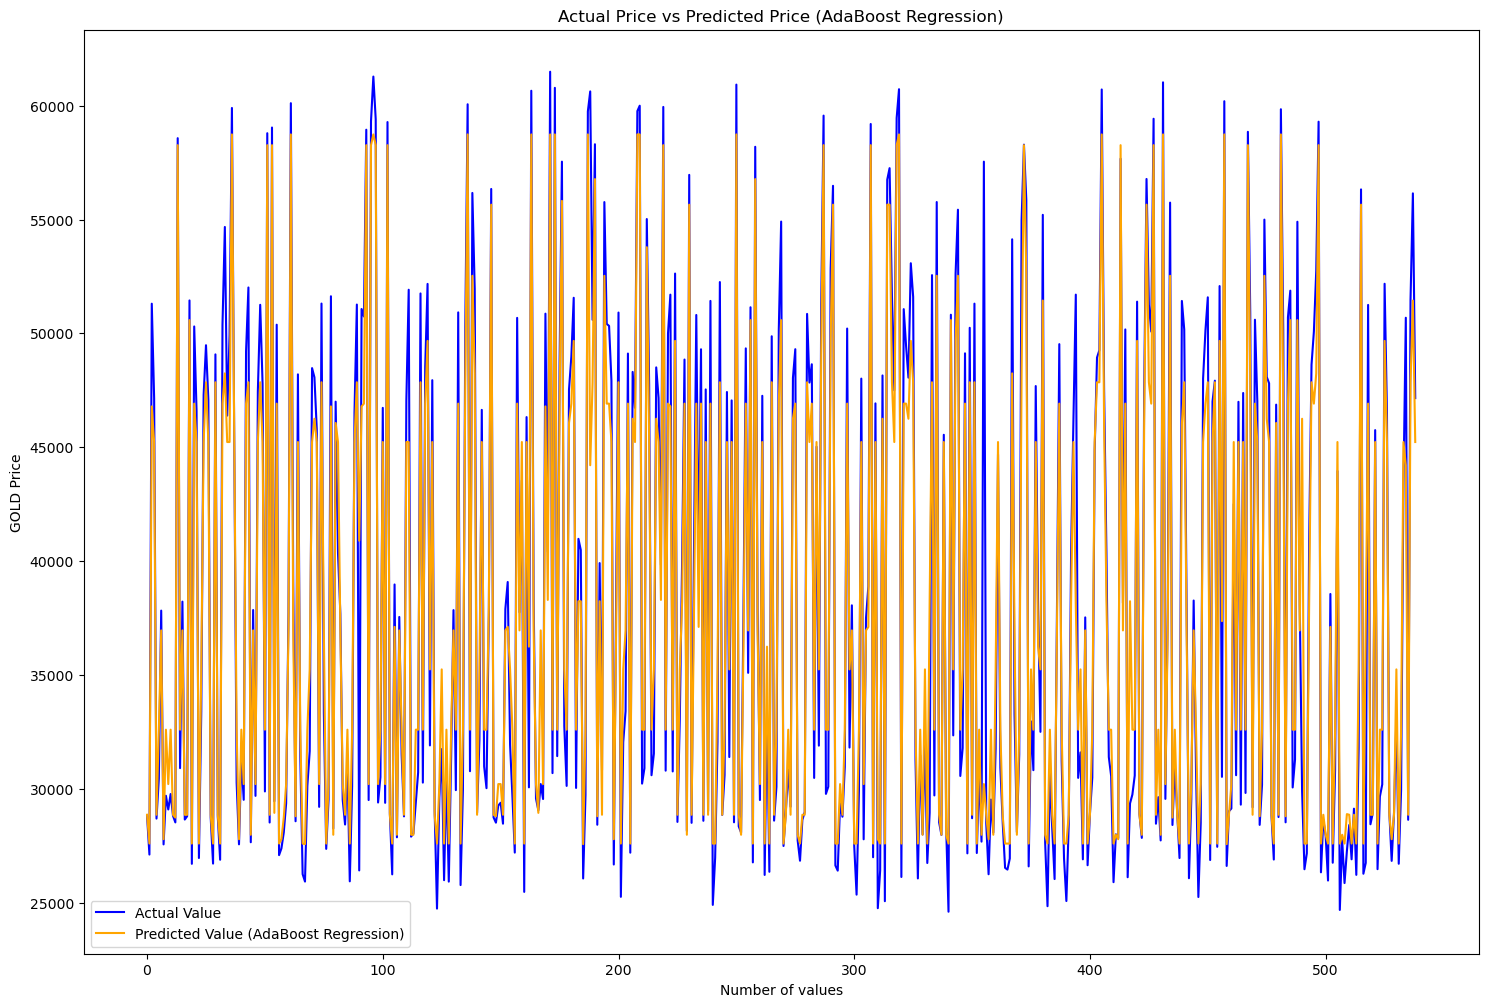

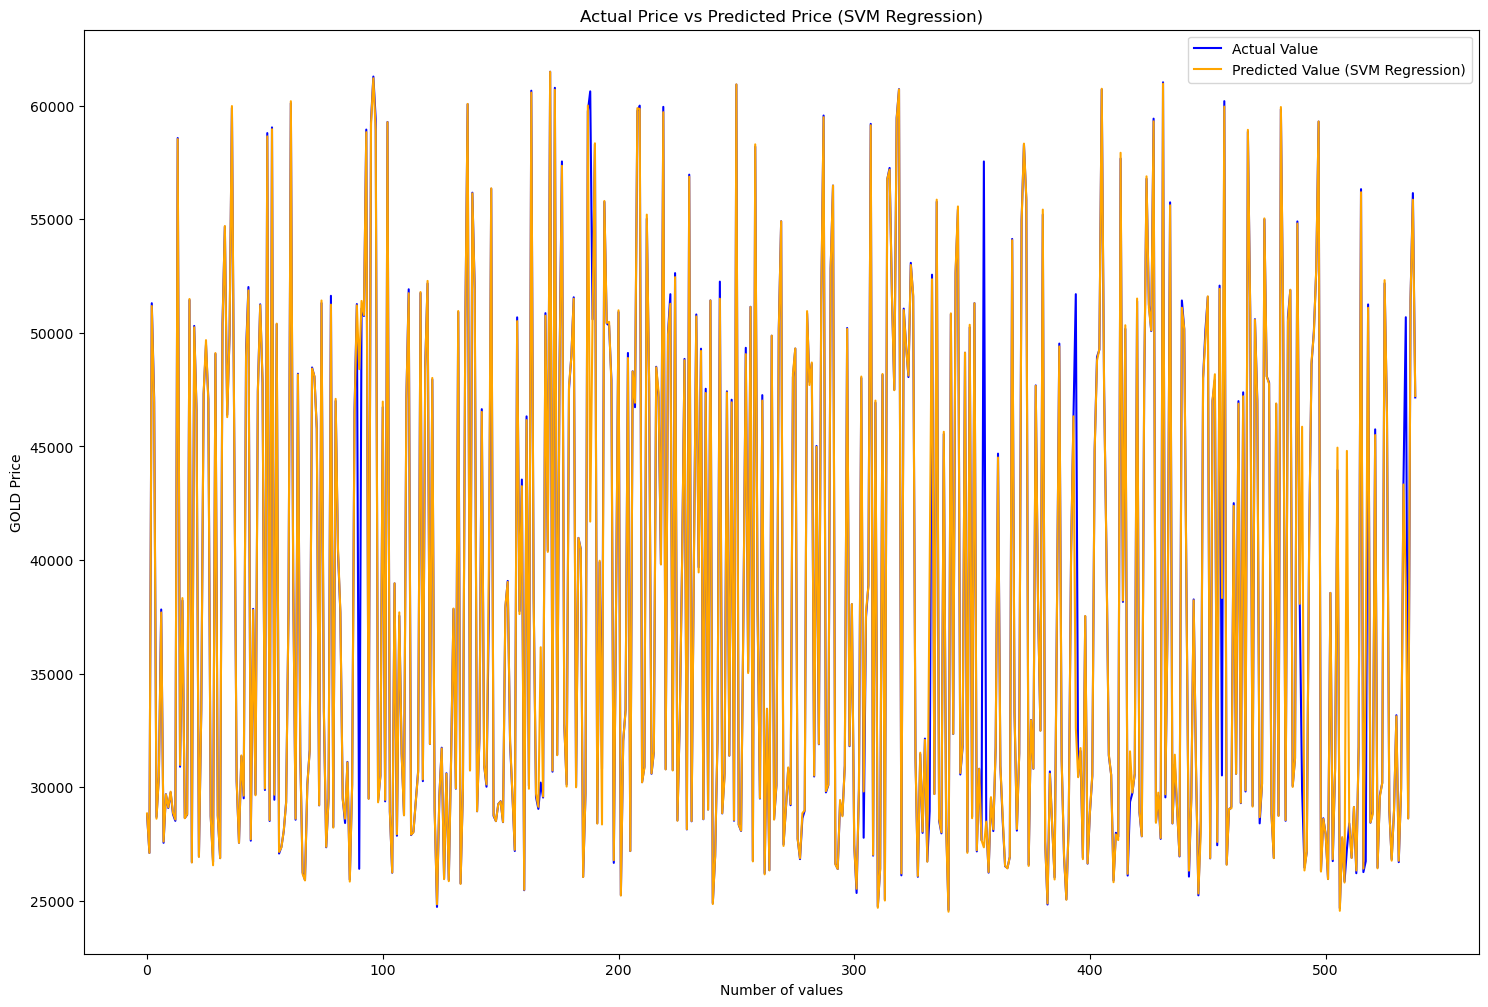

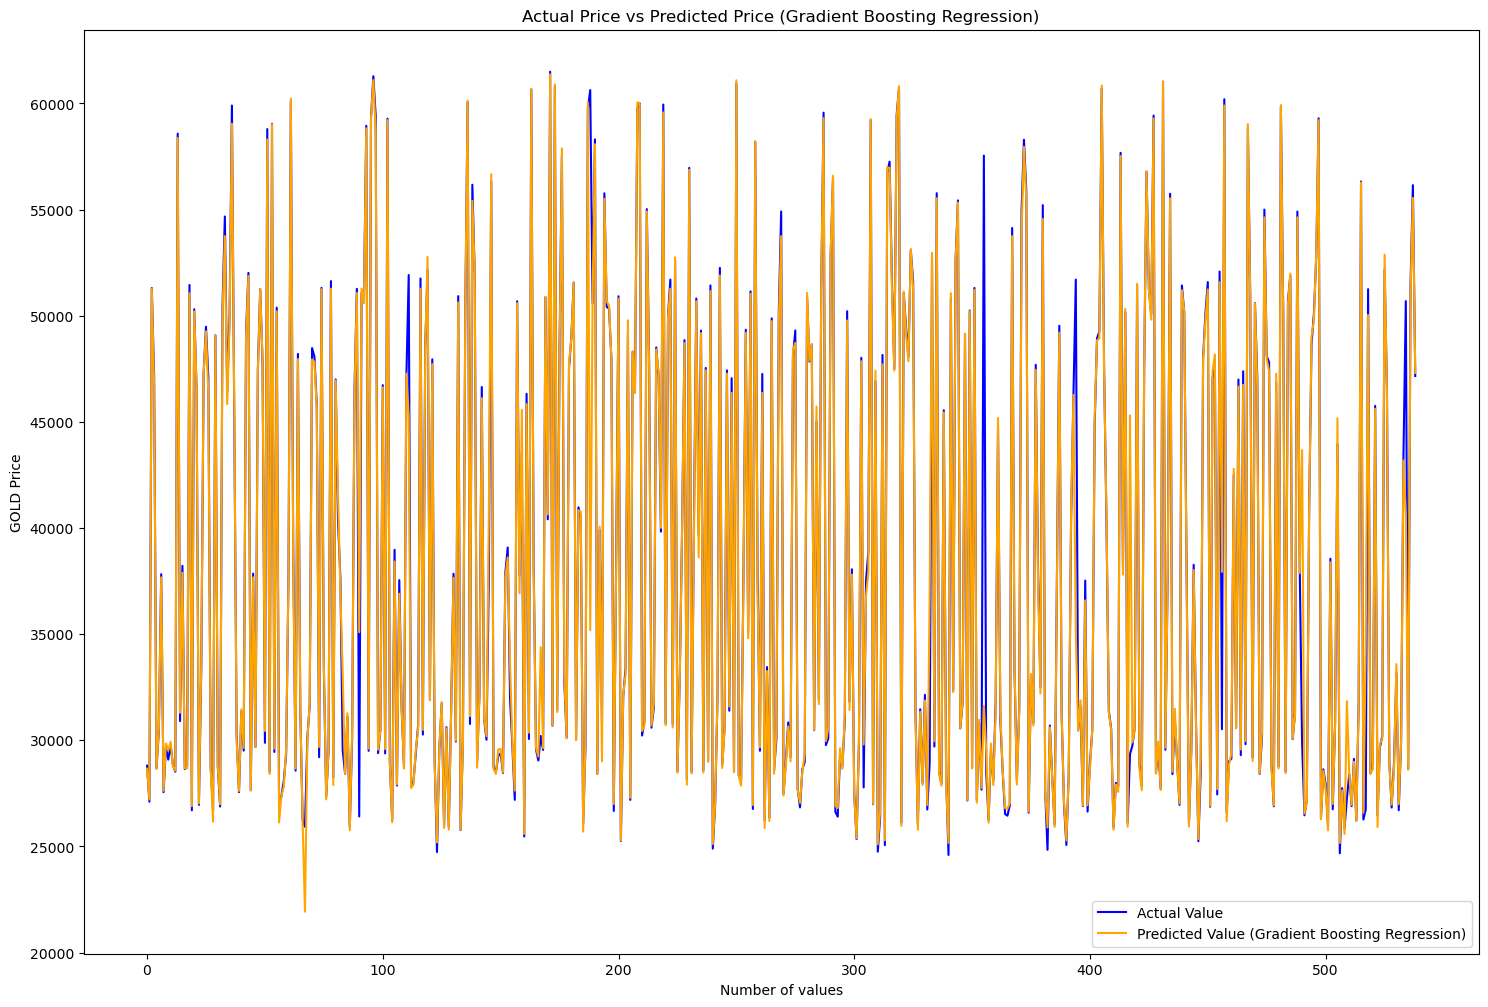

In [76]:
plt.figure(figsize=(18, 12))


plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(test_data_prediction, color='orange', label='Predicted Value (Linear Regression)')
plt.title('Actual Price vs Predicted Price (Linear Regression)')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(test_data_prediction, color='orange', label='Predicted Value (Random Forest Regression)')
plt.title('Actual Price vs Predicted Price (Random Forest Regression)')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_xgb, color='orange', label='Predicted Value (XGBoost)')
plt.title('Actual Price vs Predicted Price (XGBoost Regression)')
plt.xlabel('Number of values')
plt.ylabel('GLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_adaboost, color='orange', label='Predicted Value (AdaBoost Regression)')
plt.title('Actual Price vs Predicted Price (AdaBoost Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_svm, color='orange', label='Predicted Value (SVM Regression)')
plt.title('Actual Price vs Predicted Price (SVM Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()


plt.figure(figsize=(18, 12))
plt.plot(Y_test.values, color='blue', label='Actual Value')
plt.plot(Y_pred_gradient_boost, color='orange', label='Predicted Value (Gradient Boosting Regression)')
plt.title('Actual Price vs Predicted Price (Gradient Boosting Regression)')
plt.xlabel('Number of values')
plt.ylabel('GOLD Price')
plt.legend()
plt.show()

## SCATTERPLOT

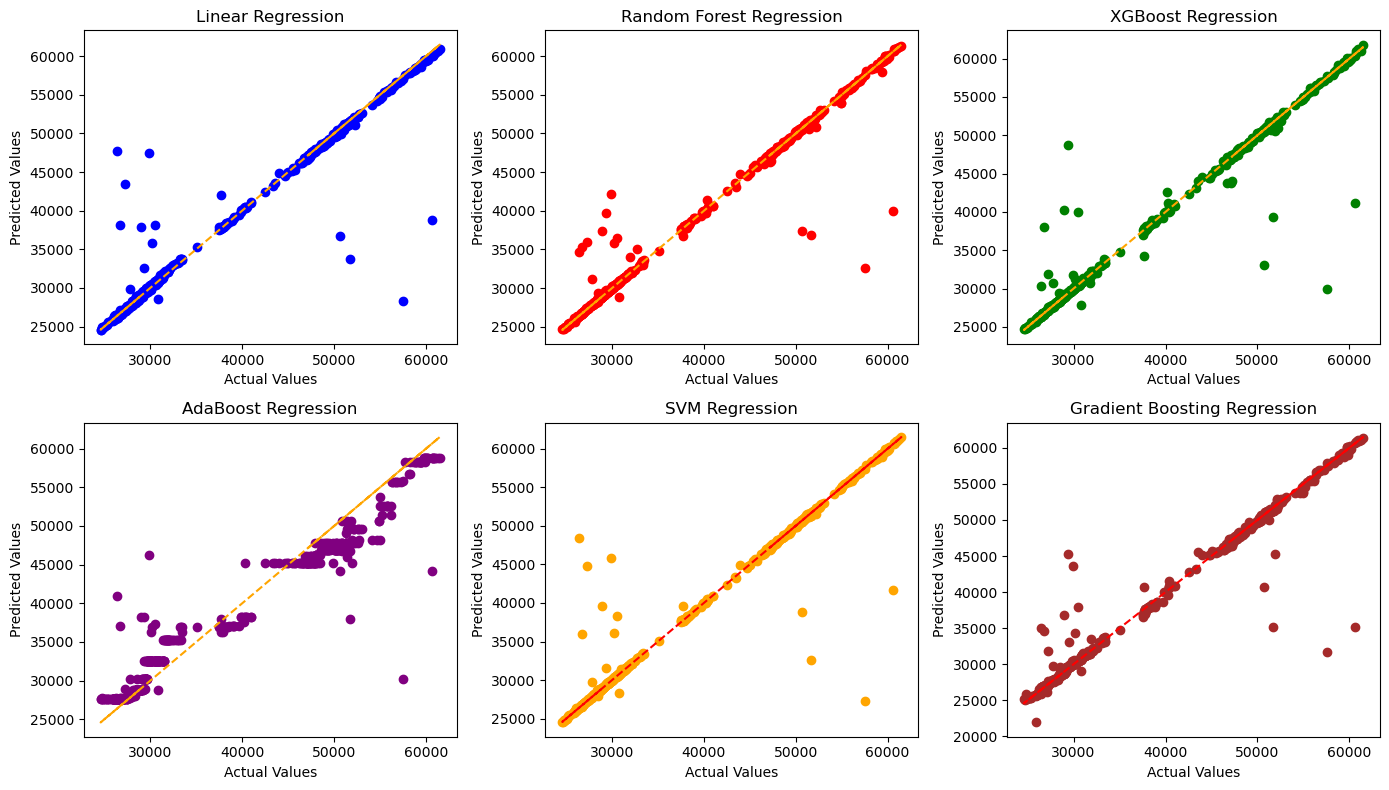

In [77]:
# Create subplots for scatterplots of each regression model
plt.figure(figsize=(14, 8))

# Linear Regression Scatterplot
plt.subplot(2, 3, 1)
plt.scatter(Y_test, test_data_prediction, color='blue')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('Linear Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Random Forest Regression Scatterplot
plt.subplot(2, 3, 2)
plt.scatter(Y_test, test_data_predictionR, color='red')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('Random Forest Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# XGBoost Regression Scatterplot
plt.subplot(2, 3, 3)
plt.scatter(Y_test, Y_pred_xgb, color='green')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('XGBoost Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# AdaBoost Regression Scatterplot
plt.subplot(2, 3, 4)
plt.scatter(Y_test, Y_pred_adaboost, color='purple')
plt.plot(Y_test, Y_test, color='orange', linestyle='--')
plt.title('AdaBoost Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# SVM Regression Scatterplot
plt.subplot(2, 3, 5)
plt.scatter(Y_test, Y_pred_svm, color='orange')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('SVM Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

# Gradient Boosting Regression Scatterplot
plt.subplot(2, 3, 6)
plt.scatter(Y_test, Y_pred_gradient_boost, color='brown')
plt.plot(Y_test, Y_test, color='red', linestyle='--')
plt.title('Gradient Boosting Regression')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

plt.tight_layout()
plt.show()



## RESIDUAL PLOT

C:\Users\sarka\anaconda3\envs\Projects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarka\anaconda3\envs\Projects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarka\anaconda3\envs\Projects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\sarka\anaconda3\envs\Projects\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a fu

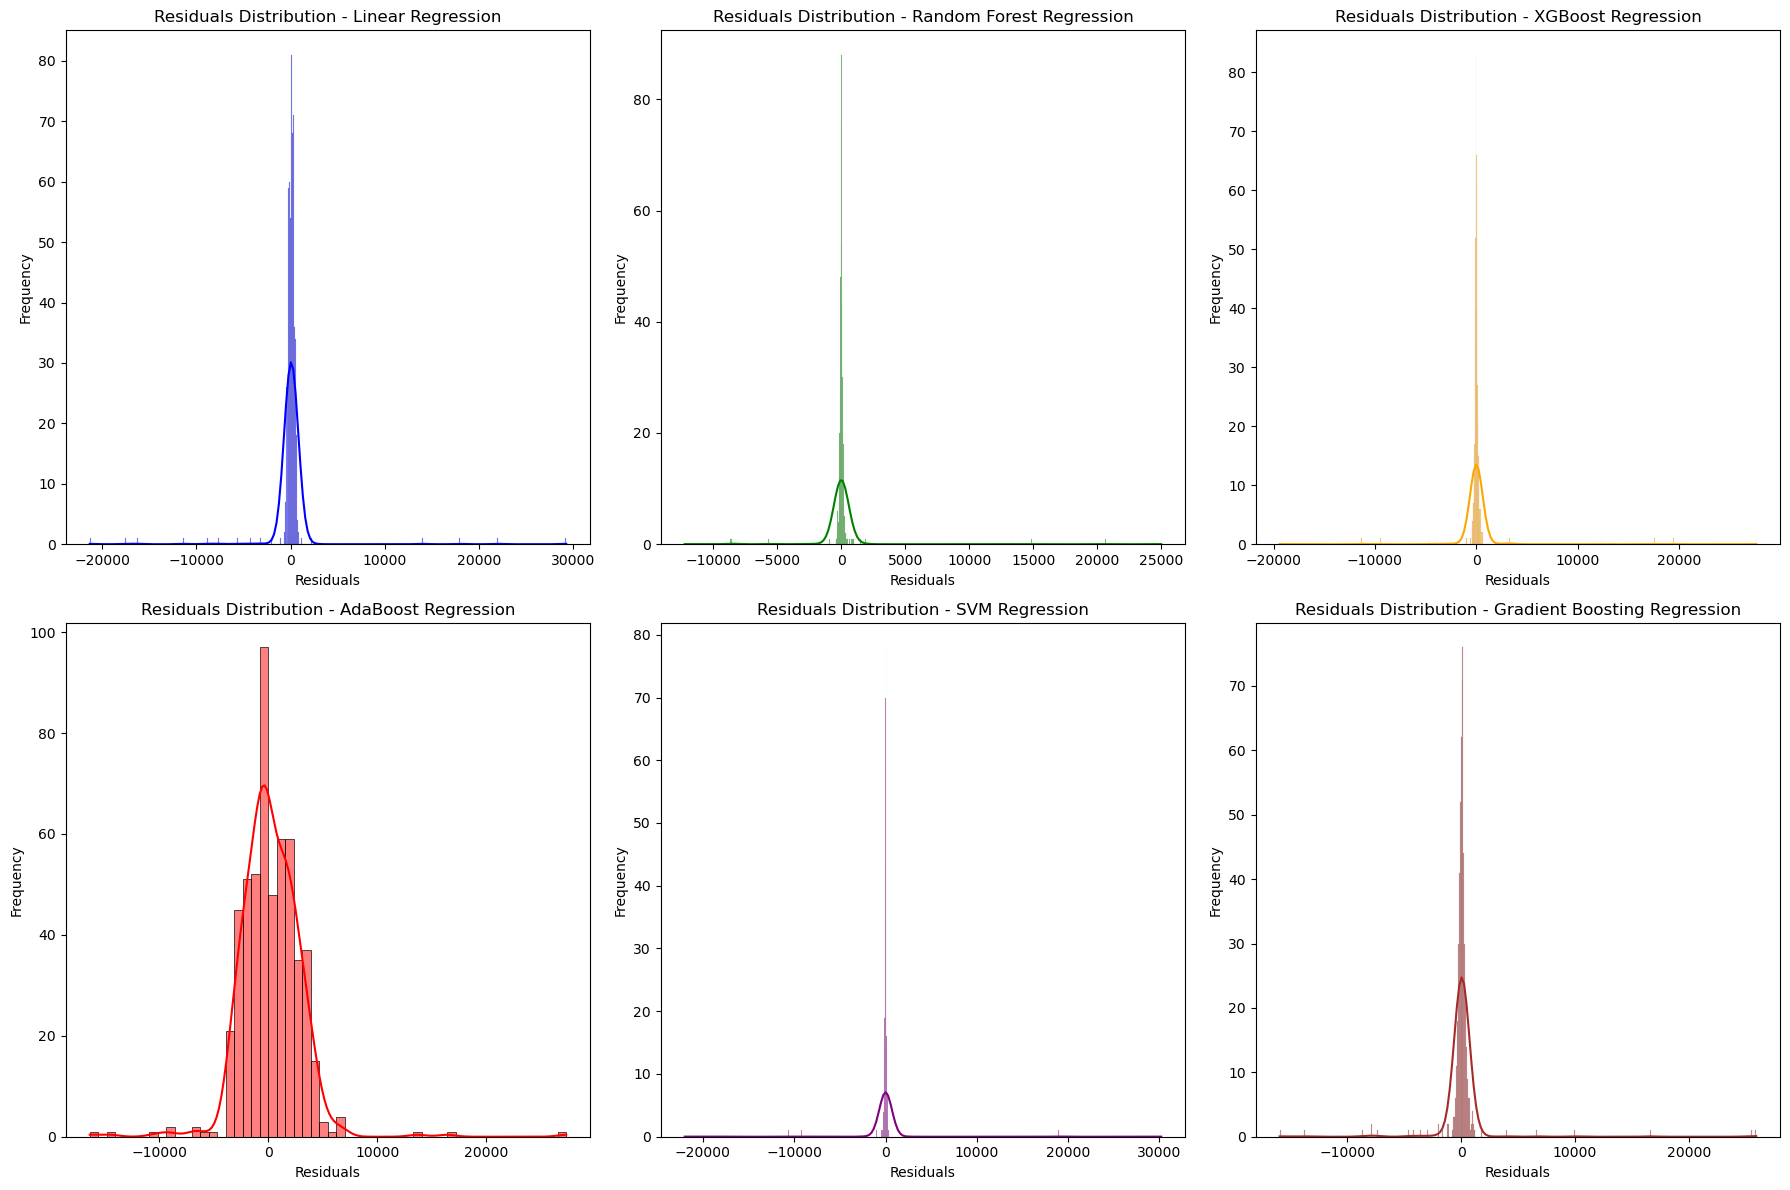

In [78]:
import seaborn as sns

# Create subplots for the distribution plots of residuals for each regression model
plt.figure(figsize=(18, 12))

# Linear Regression
plt.subplot(2, 3, 1)
sns.histplot(Y_test - test_data_prediction, kde=True, color='blue')
plt.title('Residuals Distribution - Linear Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Random Forest Regression
plt.subplot(2, 3, 2)
sns.histplot(Y_test - test_data_predictionR, kde=True, color='green')
plt.title('Residuals Distribution - Random Forest Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# XGBoost Regression
plt.subplot(2, 3, 3)
sns.histplot(Y_test - Y_pred_xgb, kde=True, color='orange')
plt.title('Residuals Distribution - XGBoost Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# AdaBoost Regression
plt.subplot(2, 3, 4)
sns.histplot(Y_test - Y_pred_adaboost, kde=True, color='red')
plt.title('Residuals Distribution - AdaBoost Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# SVM Regression
plt.subplot(2, 3, 5)
sns.histplot(Y_test - Y_pred_svm, kde=True, color='purple')
plt.title('Residuals Distribution - SVM Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

# Gradient Boosting Regression
plt.subplot(2, 3, 6)
sns.histplot(Y_test - Y_pred_gradient_boost, kde=True, color='brown')
plt.title('Residuals Distribution - Gradient Boosting Regression')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


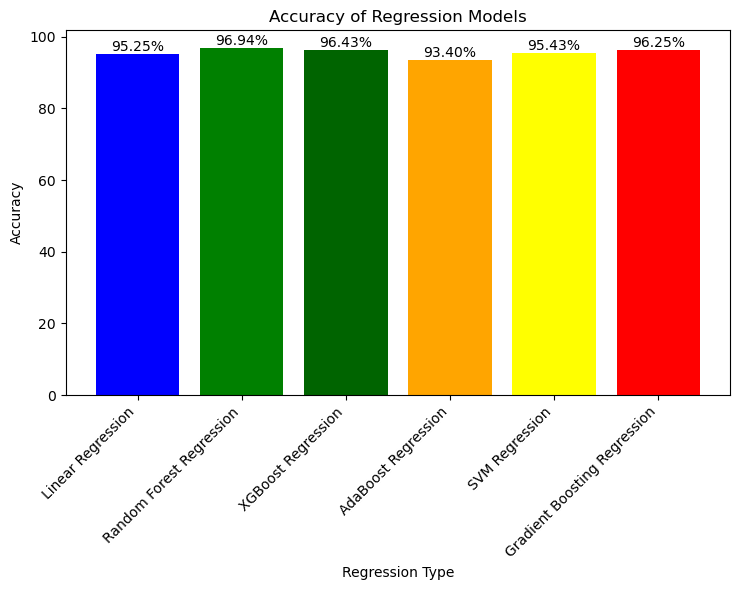

In [79]:
import matplotlib.pyplot as plt

# Data
models = ['Linear Regression', 'Random Forest Regression', 'XGBoost Regression', 
          'AdaBoost Regression', 'SVM Regression', 'Gradient Boosting Regression']
accuracy = [error_score * 100, error_scoreR * 100, r2_xgb * 100, r2_adaboost * 100, r2_svm * 100, r2_gradient_boost * 100]

# Define colors for each bar
colors = ['blue', 'green', 'darkgreen', 'orange', 'yellow', 'red']

# Create bar plot
plt.figure(figsize=(7.5, 6))

bars = plt.bar(models, accuracy, color=colors)
plt.xlabel('Regression Type')
plt.ylabel('Accuracy')
plt.title('Accuracy of Regression Models')
plt.xticks(rotation=45, ha='right')

# Annotate each bar with accuracy percentage
for bar, acc in zip(bars, accuracy):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{acc:.2f}%', ha='center', va='bottom')

plt.tight_layout()

# Show plot
plt.show()


